In [2]:
!pip install --upgrade --force-reinstall numpy matplotlib torch pandas pykan jax scikit-learn polars

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 549.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Solving Example 1...
checkpoint directory created: ./model
saving model version 0.0
Epoch 0/150, Loss: 4.646054267883301
Epoch 10/150, Loss: 0.003714174497872591
Epoch 20/150, Loss: 5.41882254765369e-05
Epoch 30/150, Loss: 4.624608209269354e-06
Epoch 40/150, Loss: 9.881097184916143e-07
Epoch 50/150, Loss: 9.535721119391383e-07
Epoch 60/150, Loss: 9.44966416227544e-07
Epoch 70/150, Loss: 9.369945246362477e-07
Epoch 80/150, Loss: 9.296483653997711e-07
Epoch 90/150, Loss: 9.227307486980862e-07
Epoch 100/150, Loss: 9.16299654818431e-07
Epoch 110/150, Loss: 9.101681257561722e-07
Epoch 120/150, Loss: 9.043546356224397e-07
Epoch 130/150, Loss: 8.989413800009061e-07
Epoch 140/150, Loss: 8.9375578227191e-07


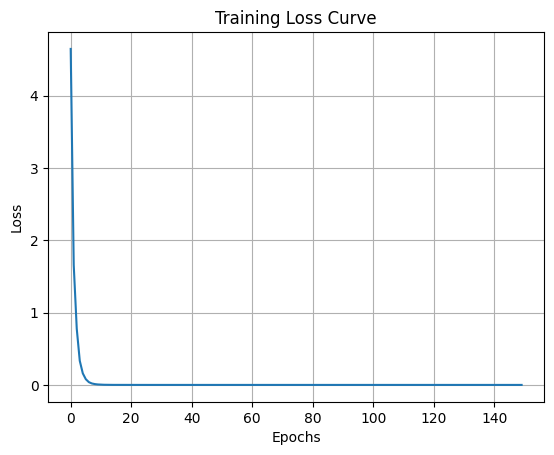

Solving Example 2...
checkpoint directory created: ./model
saving model version 0.0
Epoch 0/150, Loss: 9.826324462890625
Epoch 10/150, Loss: 0.01782851293683052
Epoch 20/150, Loss: 0.0004797825822606683
Epoch 30/150, Loss: 5.590881482930854e-05
Epoch 40/150, Loss: 1.3468562428897712e-05
Epoch 50/150, Loss: 4.2567021409922745e-06
Epoch 60/150, Loss: 3.5479799862514483e-06
Epoch 70/150, Loss: 3.5324246709933504e-06
Epoch 80/150, Loss: 3.5219852634327253e-06
Epoch 90/150, Loss: 3.5138948533131042e-06
Epoch 100/150, Loss: 3.5060261325270403e-06
Epoch 110/150, Loss: 3.499683771224227e-06
Epoch 120/150, Loss: 3.49426568391209e-06
Epoch 130/150, Loss: 3.4882521049439674e-06
Epoch 140/150, Loss: 3.4830391086870804e-06


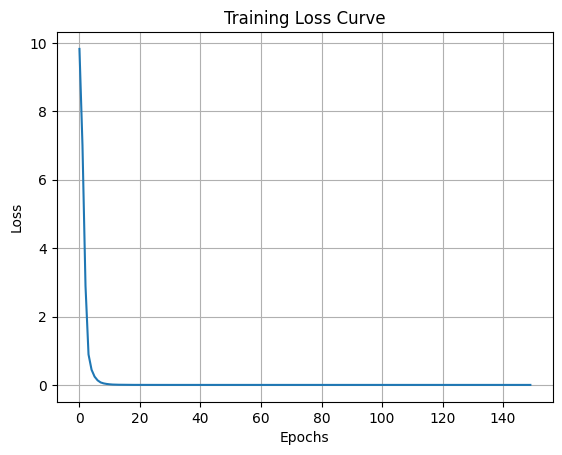

Plotting results...


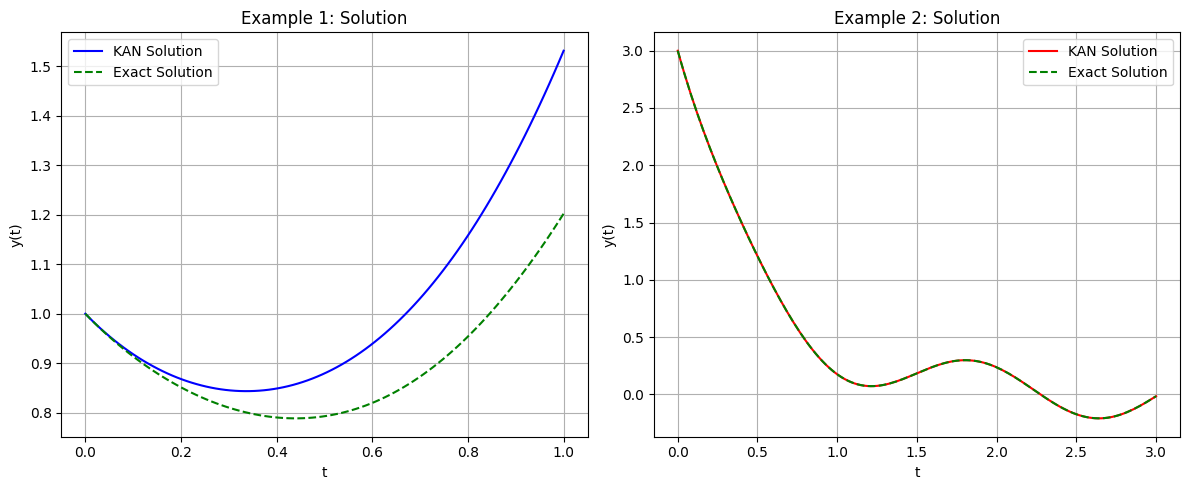

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from kan import MultKAN

def train_model_with_physics(model, epochs, optimizer, t_train, ode_residual, ic_loss_fn, patience=50):
    model.train()

    best_loss = float('inf')
    counter = 0
    losses = []

    for epoch in range(epochs):
        def closure():
            optimizer.zero_grad()
            y_pred = model(t_train)
            residual_loss = torch.mean(ode_residual(t_train, y_pred)**2)
            ic_loss = ic_loss_fn(model)
            total_loss = residual_loss + ic_loss
            total_loss.backward()
            return total_loss

        loss = optimizer.step(closure)

        if loss.item() < best_loss:
            best_loss = loss.item()
            counter = 0
        else:
            counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Log and store loss
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")
        losses.append(loss.item())

    # Plot loss curve
    plt.plot(losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.grid(True)
    plt.show()

    return model

def solve_example1():
    # Define model
    model = MultKAN(width=[1, 12, 1], grid=15, k=4, device='cpu')

    # Define ODE components
    def ode_residual(t, y):
        dy_dt = torch.autograd.grad(y, t, grad_outputs=torch.ones_like(y), create_graph=True)[0]
        f_term = ((1 + 3 * t**2) / (1 + t + t**3)) * y
        g_term = 2 * t + t**3 + t**2 * ((1 + 3 * t**2) / (1 + t + t**3))
        return dy_dt + f_term - g_term

    def ic_loss_fn(model):
        t_bc = torch.tensor([[0.0]], requires_grad=True)
        y_bc = torch.tensor([[1.0]])
        y_pred = model(t_bc)
        return torch.mean((y_pred - y_bc)**2)

    # Training data
    t_train = torch.linspace(0, 1, 100).reshape(-1, 1).requires_grad_()

    # Define optimizer
    optimizer = torch.optim.LBFGS(model.parameters(), lr=0.01, max_iter=20, tolerance_grad=1e-7, tolerance_change=1e-9, history_size=50)

    # Train model
    model = train_model_with_physics(model, epochs=150, optimizer=optimizer, t_train=t_train, ode_residual=ode_residual, ic_loss_fn=ic_loss_fn)

    # Evaluate and plot
    t_eval = torch.linspace(0, 1, 100).reshape(-1, 1).requires_grad_()
    y_pred = model(t_eval).detach().numpy()
    t_eval_np = t_eval.detach().numpy()
    y_exact_eval = (np.exp(-t_eval_np**2 / 2) + t_eval_np**5 + t_eval_np**3 + t_eval_np**2) / (t_eval_np**3 + t_eval_np + 1)

    return t_eval_np, y_pred, y_exact_eval

def solve_example2():
    # Define model
    model = MultKAN(width=[1, 12, 1], grid=15, k=4, device='cpu')

    # Define ODE components
    def ode_residual(t, y):
        dy_dt = torch.autograd.grad(y, t, grad_outputs=torch.ones_like(y), create_graph=True)[0]
        f_term = 2 * y
        g_term = torch.cos(4 * t)
        return dy_dt + f_term - g_term

    def ic_loss_fn(model):
        t_bc = torch.tensor([[0.0]], requires_grad=True)
        y_bc = torch.tensor([[3.0]])
        y_pred = model(t_bc)
        return torch.mean((y_pred - y_bc)**2)

    # Training data
    t_train = torch.linspace(0, 3, 150).reshape(-1, 1).requires_grad_()

    # Define optimizer
    optimizer = torch.optim.LBFGS(model.parameters(), lr=0.01, max_iter=20, tolerance_grad=1e-7, tolerance_change=1e-9, history_size=50)

    # Train model
    model = train_model_with_physics(model, epochs=150, optimizer=optimizer, t_train=t_train, ode_residual=ode_residual, ic_loss_fn=ic_loss_fn)

    # Evaluate and plot
    t_eval = torch.linspace(0, 3, 150).reshape(-1, 1).requires_grad_()
    y_pred = model(t_eval).detach().numpy()
    t_eval_np = t_eval.detach().numpy()
    y_exact_eval = (np.sin(4 * t_eval_np) / 5 + np.cos(4 * t_eval_np) / 10 + 2.9 * np.exp(-2 * t_eval_np))

    return t_eval_np, y_pred, y_exact_eval

def plot_results(t1, y1, y1_exact, t2, y2, y2_exact):
    plt.figure(figsize=(12, 5))

    # Plot Example 1
    plt.subplot(1, 2, 1)
    plt.plot(t1, y1, 'b-', label='KAN Solution')
    plt.plot(t1, y1_exact, 'g--', label='Exact Solution')
    plt.title('Example 1: Solution')
    plt.xlabel('t')
    plt.ylabel('y(t)')
    plt.grid(True)
    plt.legend()

    # Plot Example 2
    plt.subplot(1, 2, 2)
    plt.plot(t2, y2, 'r-', label='KAN Solution')
    plt.plot(t2, y2_exact, 'g--', label='Exact Solution')
    plt.title('Example 2: Solution')
    plt.xlabel('t')
    plt.ylabel('y(t)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    print("Solving Example 1...")
    t1, y1, y1_exact = solve_example1()

    print("Solving Example 2...")
    t2, y2, y2_exact = solve_example2()

    print("Plotting results...")
    plot_results(t1, y1, y1_exact, t2, y2, y2_exact)

if __name__ == "__main__":
    main()
